In [2]:
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import sentiwordnet as swn
import math
from math import exp, expm1, log, log10
import numpy as np
import turtle
import pandas as pd
from nltk.wsd import lesk
from pycorenlp import StanfordCoreNLP
from pywsd.lesk import simple_lesk

nlp = StanfordCoreNLP('http://localhost:9000')
dependency_parser = nlp.annotate

Warming up PyWSD (takes ~10 secs)... took 5.321674346923828 secs.


In [97]:
def analyse_file(key, filename):
    try:
        file = open(filename, 'r')
    except (BaseExceptionException,e):
        print ('Invalid File!')
        return 'Error'  
    doc = file.read()
    lines = doc.split("\n")
    file.close()
    
    radii = get_TDOC(lines, key)    
#     print (radii)
    return radii, lines

def get_TDOC(lines, key):
    freq = {'Init': 0}              #Number of times context term occurs with key
    freq.clear()
    prohib=['']
    for line in lines:
        words = line.split(" ")
        if key in words:
            for context in words:
                flag=0
                for i in prohib:
                    if i == context:
                        flag=1
                        break
                if flag==0 and context!=key:
                    freq.setdefault(context, 0)
                    freq[context] = freq.get(context) + 1
                                           
    N = 0                           #Total Number of terms in Document
    for line in lines:
        words = line.split(" ")
        N += len(words)

    Nci = {'Init': 0}               #Total terms that occur with context term
    Nci.clear()
    for context in freq.keys():
        for line in lines:
            words = line.split(" ")
            if context in words:
                Nci.setdefault(context, 0)
                Nci[context] += len(words)

    radii = {'Init': 0}             #Get Radius of context term with TDOC formula
    radii.clear()
    
    df = pd.DataFrame(columns=['c', 'm', 'N', 'Nc', 'f', 'N/Nc', 'log(N/Nc)', 'fxlog(N/Nc)', '/4'])
    
    for term in freq.keys():
        radii[term] = (freq[term]*(log(N/Nci[term])))/3
    
        df = df.append({'c': term,
                'm': key,
                'N': N,
                'Nc': Nci[term],
                'f': freq[term],
                'N/Nc': "{0:.2f}".format(N/Nci[term]),
                'log(N/Nc)': "{0:.2f}".format(log(N/Nci[term])),
                'fxlog(N/Nc)': "{0:.2f}".format(freq[term]*(log(N/Nci[term]))),
                '/4': "{0:.2f}".format((freq[term]*(log(N/Nci[term])))/4)
               }, ignore_index=True)
    
#     df.to_excel("tdoc2.xlsx")
    return radii                    #Returns entire set of context terms related to key

def pos_tag(sentence):
    result = dependency_parser(sentence, properties={"outputFormat": "json", "annotators": "pos"})['sentences'][0]['tokens']
    res = []
    for pos in result:
        res.append((pos['word'], pos['pos']))
    return res

def get_theta(key, sentences):
    print(len(sentences), key)
    scores = []
    for sentence in sentences:
        flag = True
        
        pp_tagged = pos_tag(sentence)
        tagged = ('','')
        for p in pp_tagged:
            if p[0] == key:
                tagged = p
        if tagged == ('', ''):
            flag = False
        
        ambiguous = tagged[0]
        tag = tagged[1]
        pos = ''

        if 'NN' in tag:
            pos = 'n'
        elif 'NNS' in tag:
            pos = 'nns'
        elif 'VB' in tag:
            pos = 'v'
        elif 'VBG' in tag:
            pos = 'v'
        elif 'JJ' in tag:
            pos = 'a'
        elif 'RB' in tag:
            pos = 'r'
        else:
            flag = False

        if flag:
            answer = simple_lesk(sentence, ambiguous, pos)
            if answer:
                score = swn.senti_synset(answer.name())
                if score.pos_score() > 0.0:
                    scores.append(score.pos_score())
                else:
                    scores.append(score.obj_score()*(-1))
            else:
                scores.append(0)
        else:
            scores.append(0)
        
    final_score = np.average(scores)
#     print(final_score)
    return np.pi * final_score

In [98]:
def graph(radii, theta):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot([0,0],[-1,1])
    plt.plot([-1,1],[0,0])
    plt.axis([-1,1,-1,1])
    i=0
    a=[]
    b=[]
    rad=list(radii.values())
    theta1=list(theta.values())

    while(i<len(radii)):
        a.append(rad[i]*math.cos(theta1[i]))
        b.append(rad[i]*math.sin(theta1[i]))
        i+=1 
    plt.scatter(a,b,label="circles",color="r",marker="o",s=10)
    q = 0
    rad2=list(radii.keys())
    for i,j in zip(a,b):
        ax.annotate('%s' %rad2[q], xy=(i,j), xytext=(15,0), textcoords='offset points')
        q = q+1    

    ax.add_artist(plt.Circle((0,0),1.0,color='b',fill=False))
    plt.xlabel('Sentiment Strength')
    plt.ylabel('Orientation')
    plt.title(key)
    plt.savefig("graph.png")

In [101]:
def prior_sentiment(radii, key, all_sentences):
    theta = {'Init': 0}
    theta.clear()
    for word in radii.keys():
        sentences = []
        for sentence in all_sentences:
            words = sentence.split(' ')
            if (word in words) and (key in words):
                sentences.append(sentence)
        
#         print(word, len(sentences))
        filter = get_theta(word, sentences)            #if function returns 0 word does not exist in lexicon
        theta[word] = filter
        
    return theta

the 114
114 the
is 65
65 is
very 15
15 very
easy 7
7 easy
to 57
57 to
use 18
18 use
, 90
90 ,
in 31
31 in
fact 4
4 fact
on 22
22 on
a 81
81 a
recent 1
1 recent
trip 1
1 trip
this 80
80 this
past 1
1 past
week 2
2 week
i 77
77 i
was 8
8 was
asked 2
2 asked
take 8
8 take
picture 5
5 picture
of 44
44 of
vacationing 1
1 vacationing
elderly 1
1 elderly
group 1
1 group
. 154
154 .
after 7
7 after
took 2
2 took
their 2
2 their
with 33
33 with
they 10
10 they
offered 1
1 offered
us 2
2 us
bottom 2
2 bottom
line 2
2 line
well 6
6 well
made 3
3 made
flexible 1
1 flexible
and 78
78 and
powerful 1
1 powerful
features 10
10 features
include 1
1 include
ability 3
3 ability
external 3
3 external
flash 4
4 flash
lense 1
1 lense
/ 2
2 /
filters 1
1 filters
choices 2
2 choices
'd 3
3 'd
highly 4
4 highly
recommend 5
5 recommend
for 31
31 for
anyone 1
1 anyone
who 5
5 who
looking 6
6 looking
excellent 3
3 excellent
quality 9
9 quality
pictures 6
6 pictures
combination 2
2 combination
ease 1
1 ease
flexib

plug-in 2
2 plug-in
shows 1
1 shows
hardware 1
1 hardware
miles 1
1 miles
ahead 1
1 ahead
least 1
1 least
youre 1
1 youre
starting 1
1 starting
most 5
5 most
photorealistic 1
1 photorealistic
ive 1
1 ive
ever 4
4 ever
seen 4
4 seen
perfect 3
3 perfect
hobbiest 1
1 hobbiest
wants 1
1 wants
girlfriend 1
1 girlfriend
loved 1
1 loved
pry 1
1 pry
her 2
2 her
hands 2
2 hands
consumer 2
2 consumer
reports 1
1 reports
reading 1
1 reading
positive 2
2 positive
leading 1
1 leading
magazine 1
1 magazine
decided 3
3 decided
head 2
2 head
read 1
1 read
objections 1
1 objections
naysayers 1
1 naysayers
almost 3
3 almost
caused 1
1 caused
different 3
3 different
end 1
1 end
figured 1
1 figured
give 2
2 give
try 2
2 try
arrived 1
1 arrived
condition 1
1 condition
dream 1
1 dream
operate 1
1 operate
automode 1
1 automode
tremendous 1
1 tremendous
modes 1
1 modes
write 2
2 write
things 2
2 things
course 1
1 course
such 2
2 such
tool 1
1 tool
shelves 1
1 shelves
separately 1
1 separately
helps 1
1 helps


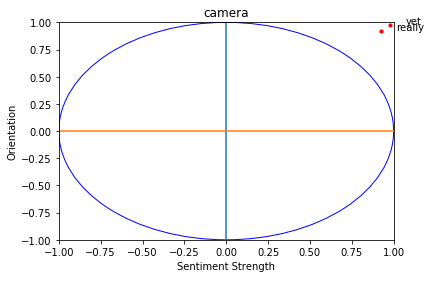

In [103]:
key = "camera"
radii, lines = analyse_file(key, "coba.txt")
theta = prior_sentiment(radii, key, lines)
graph(radii, theta)
print(theta['easy'])